# GPU-Accelerated Quantitative Portfolio Optimization

**Production-Grade Portfolio Construction with cuProx**

This notebook demonstrates institutional-quality portfolio optimization:

1. **Modern Portfolio Theory** - Markowitz mean-variance with proper QP formulation
2. **Risk Metrics Dashboard** - VaR, CVaR, Maximum Drawdown, Sharpe, Sortino
3. **Monte Carlo Stress Testing** - 10,000 scenario simulation
4. **Efficient Frontier Analysis** - Capital Market Line and tangency portfolio
5. **Rolling Window Backtesting** - Out-of-sample performance analysis
6. **GPU vs CPU Benchmarks** - Scalability analysis to 1000+ assets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import time
import sys
sys.path.insert(0, '../python')

import cuprox

plt.style.use('dark_background')
plt.rcParams.update({
    'figure.facecolor': '#0d1117',
    'axes.facecolor': '#161b22',
    'axes.edgecolor': '#30363d',
    'figure.figsize': (14, 8),
    'font.family': 'monospace'
})

COLORS = {'primary': '#58a6ff', 'secondary': '#f78166', 'success': '#3fb950',
          'warning': '#d29922', 'danger': '#f85149', 'purple': '#a371f7',
          'cyan': '#56d4dd', 'gold': '#e3b341'}

print(f'cuProx version: {cuprox.__version__}')
print(f'GPU Available: {cuprox.__cuda_available__}')

cuProx version: 0.1.0
GPU Available: True


## 1. Multi-Factor Market Data Generation

Generate realistic equity returns with sector structure and factor exposures:

In [2]:
np.random.seed(42)

SECTORS = {
    'Technology': ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'META'],
    'Finance': ['JPM', 'BAC', 'GS', 'MS', 'WFC'],
    'Healthcare': ['JNJ', 'UNH', 'PFE', 'MRK', 'ABBV'],
    'Energy': ['XOM', 'CVX', 'COP', 'SLB', 'EOG'],
    'Consumer': ['AMZN', 'TSLA', 'HD', 'NKE', 'MCD']
}

n_assets = sum(len(v) for v in SECTORS.values())
n_days = 252 * 5
asset_names = [s for sector in SECTORS.values() for s in sector]

sector_map = {stock: sector for sector, stocks in SECTORS.items() for stock in stocks}
sector_colors = {'Technology': COLORS['primary'], 'Finance': COLORS['success'],
                 'Healthcare': COLORS['purple'], 'Energy': COLORS['warning'],
                 'Consumer': COLORS['secondary']}

# Multi-factor model
n_factors = 5
factor_returns = np.random.randn(n_days, n_factors) * np.array([0.01, 0.005, 0.004, 0.006, 0.003])
factor_loadings = np.random.randn(n_assets, n_factors) * 0.3
factor_loadings[:, 0] = np.random.uniform(0.8, 1.4, n_assets)  # Market beta

idio_vol = np.random.uniform(0.15, 0.35, n_assets) / np.sqrt(252)
returns = factor_returns @ factor_loadings.T + np.random.randn(n_days, n_assets) * idio_vol

sector_drifts = {'Technology': 0.0003, 'Finance': 0.0001, 'Healthcare': 0.00015,
                 'Energy': -0.00005, 'Consumer': 0.0002}
for i, stock in enumerate(asset_names):
    returns[:, i] += sector_drifts[sector_map[stock]]

mu = np.mean(returns, axis=0) * 252
Sigma = np.cov(returns.T) * 252

print(f'Universe: {n_assets} assets across {len(SECTORS)} sectors')
print(f'History: {n_days} days ({n_days/252:.0f} years)')
print(f'Return Range: [{mu.min()*100:.1f}%, {mu.max()*100:.1f}%]')
print(f'Vol Range: [{np.sqrt(np.diag(Sigma)).min()*100:.1f}%, {np.sqrt(np.diag(Sigma)).max()*100:.1f}%]')

Universe: 25 assets across 5 sectors
History: 1260 days (5 years)
Return Range: [-20.1%, 29.5%]
Vol Range: [23.3%, 39.4%]


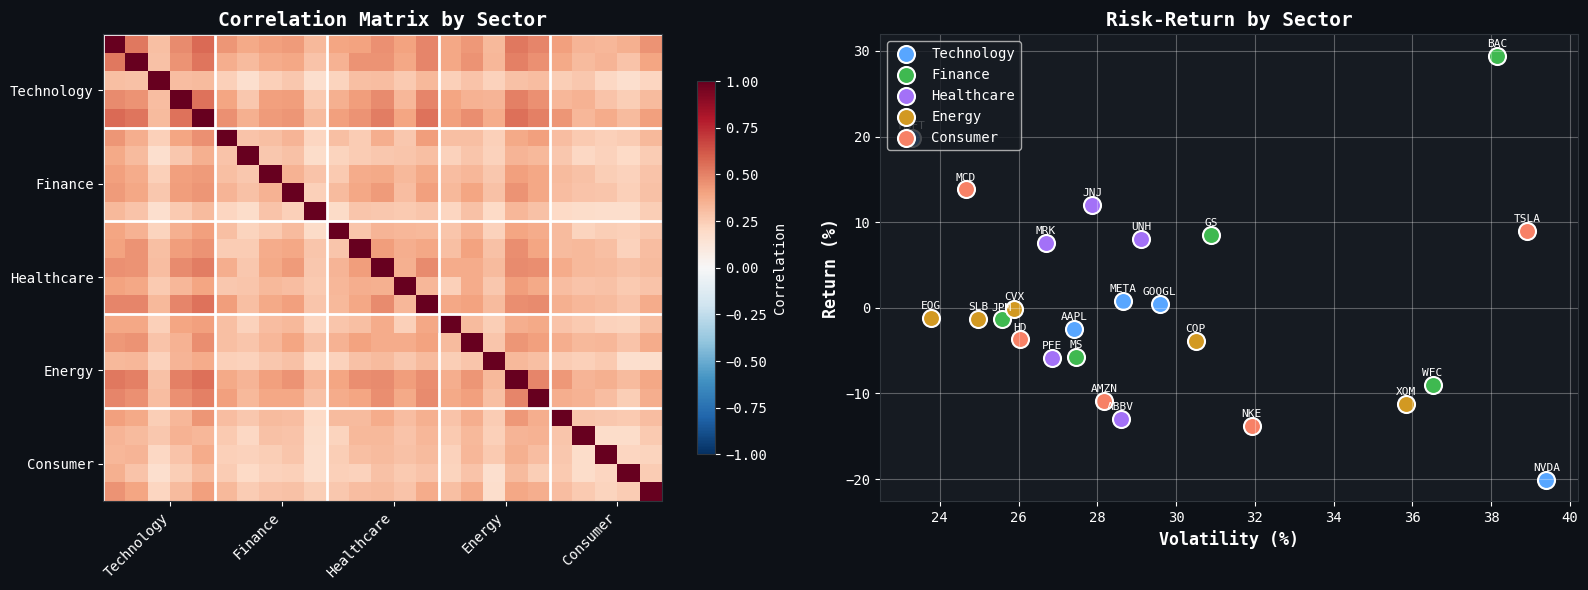

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Correlation heatmap
ax = axes[0]
corr = np.corrcoef(returns.T)
im = ax.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
cumsum = np.cumsum([0] + [len(v) for v in SECTORS.values()])
for i in range(len(cumsum)-1):
    ax.axhline(cumsum[i]-0.5, color='white', linewidth=2)
    ax.axvline(cumsum[i]-0.5, color='white', linewidth=2)
ax.set_xticks(cumsum[:-1] + np.diff(cumsum)/2)
ax.set_xticklabels(SECTORS.keys(), rotation=45, ha='right')
ax.set_yticks(cumsum[:-1] + np.diff(cumsum)/2)
ax.set_yticklabels(SECTORS.keys())
ax.set_title('Correlation Matrix by Sector', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='Correlation', shrink=0.8)

# Risk-Return scatter
ax = axes[1]
for sector, stocks in SECTORS.items():
    indices = [asset_names.index(s) for s in stocks]
    vols = np.sqrt(np.diag(Sigma))[indices] * 100
    rets = mu[indices] * 100
    ax.scatter(vols, rets, s=150, c=sector_colors[sector], label=sector,
               edgecolor='white', linewidth=1.5)
    for i, stock in enumerate(stocks):
        ax.annotate(stock, (vols[i], rets[i]), fontsize=8, ha='center', va='bottom',
                    xytext=(0, 5), textcoords='offset points')
ax.set_xlabel('Volatility (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Return (%)', fontsize=12, fontweight='bold')
ax.set_title('Risk-Return by Sector', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('portfolio_universe.png', dpi=150, bbox_inches='tight', facecolor='#0d1117')
plt.show()

## 2. Quadratic Programming Portfolio Optimization

Direct QP formulation: $\min_w \frac{\gamma}{2} w^T \Sigma w - \mu^T w$ s.t. $\mathbf{1}^T w = 1, w \geq 0$

In [4]:
def solve_markowitz(mu, Sigma, gamma=1.0):
    n = len(mu)
    P = gamma * Sigma
    c = -mu
    A_eq = np.ones((1, n))
    b_eq = np.array([1.0])
    lb = np.zeros(n)
    ub = np.ones(n)
    
    start = time.time()
    result = cuprox.solve(c=c, P=P, A=A_eq, b=b_eq, constraint_senses=['='],
                          lb=lb, ub=ub)
    solve_time = time.time() - start
    
    w = result.x
    # Post-process: clip to [0,1] and renormalize (ADMM may violate bounds slightly)
    w = np.clip(w, 0, 1)
    w = w / w.sum() if w.sum() > 0 else np.ones(n) / n
    
    port_return = w @ mu
    port_vol = np.sqrt(w @ Sigma @ w)
    sharpe = port_return / port_vol if port_vol > 1e-6 else 0
    
    return {'weights': w, 'return': port_return, 'volatility': port_vol,
            'sharpe': sharpe, 'solve_time': solve_time}

print('Portfolio Optimization Results:')
print('='*70)
for gamma in [0.5, 1.0, 2.0, 5.0, 10.0]:
    res = solve_markowitz(mu, Sigma, gamma=gamma)
    top5 = np.argsort(res['weights'])[-5:][::-1]
    holdings = ', '.join([f"{asset_names[i]}:{res['weights'][i]*100:.1f}%" for i in top5])
    print(f"gamma={gamma:4.1f}: Ret={res['return']*100:5.2f}% Vol={res['volatility']*100:5.2f}% "
          f"Sharpe={res['sharpe']:5.2f} Time={res['solve_time']*1000:.1f}ms")
    print(f"         Top: {holdings}")

Portfolio Optimization Results:


gamma= 0.5: Ret=11.58% Vol=18.70% Sharpe= 0.62 Time=236.7ms
         Top: MCD:10.6%, TSLA:10.6%, JNJ:10.6%, MSFT:10.6%, BAC:10.6%
gamma= 1.0: Ret=12.62% Vol=18.57% Sharpe= 0.68 Time=9.2ms
         Top: MCD:11.7%, GS:11.7%, BAC:11.7%, UNH:11.7%, MSFT:11.7%
gamma= 2.0: Ret=14.44% Vol=18.38% Sharpe= 0.79 Time=9.5ms
         Top: MCD:15.4%, BAC:15.4%, MSFT:15.4%, JNJ:15.4%, GS:10.7%
gamma= 5.0: Ret=15.14% Vol=17.98% Sharpe= 0.84 Time=10.5ms
         Top: MSFT:25.5%, MCD:19.1%, JNJ:13.6%, BAC:12.9%, GS:7.5%
gamma=10.0: Ret=14.41% Vol=17.64% Sharpe= 0.82 Time=11.1ms
         Top: MSFT:30.2%, MCD:17.9%, JNJ:12.0%, BAC:9.9%, MRK:6.3%


## 3. Efficient Frontier with Capital Market Line

In [5]:
n_points = 100
gammas = np.logspace(-1, 2, n_points)
frontier = {'gamma': [], 'return': [], 'volatility': [], 'sharpe': [], 'weights': []}

print('Computing efficient frontier...')
start = time.time()
for gamma in gammas:
    res = solve_markowitz(mu, Sigma, gamma=gamma)
    if res['volatility'] > 0.001 and 0 < res['return'] < 1.0:
        frontier['gamma'].append(gamma)
        frontier['return'].append(res['return'])
        frontier['volatility'].append(res['volatility'])
        frontier['sharpe'].append(res['sharpe'])
        frontier['weights'].append(res['weights'])

print(f'Computed {len(frontier["return"])} points in {(time.time()-start)*1000:.0f}ms')

max_sharpe_idx = np.argmax(frontier['sharpe'])
tangency = {k: frontier[k][max_sharpe_idx] for k in ['return', 'volatility', 'sharpe', 'weights']}
min_vol_idx = np.argmin(frontier['volatility'])
minvar = {k: frontier[k][min_vol_idx] for k in ['return', 'volatility', 'sharpe', 'weights']}

print(f"Tangency: Ret={tangency['return']*100:.2f}% Vol={tangency['volatility']*100:.2f}% Sharpe={tangency['sharpe']:.3f}")
print(f"MinVar: Ret={minvar['return']*100:.2f}% Vol={minvar['volatility']*100:.2f}% Sharpe={minvar['sharpe']:.3f}")

Computing efficient frontier...


Computed 100 points in 1156ms
Tangency: Ret=15.22% Vol=17.93% Sharpe=0.849
MinVar: Ret=4.96% Vol=16.04% Sharpe=0.309


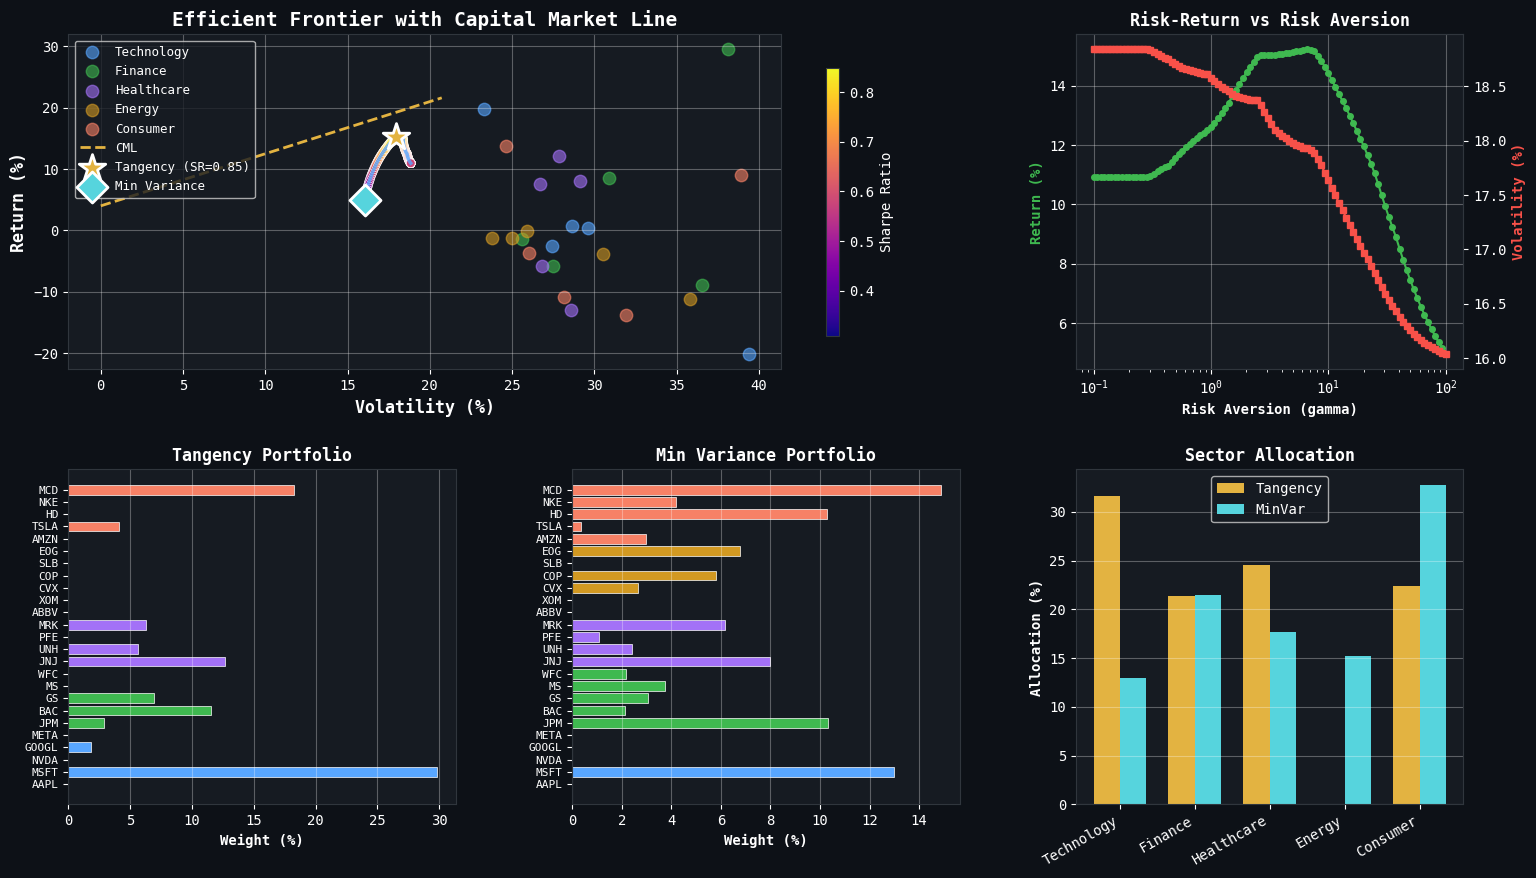

In [6]:
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

# Main frontier plot
ax1 = fig.add_subplot(gs[0, :2])
asset_vols = np.sqrt(np.diag(Sigma)) * 100
asset_rets = mu * 100
for sector, stocks in SECTORS.items():
    idx = [asset_names.index(s) for s in stocks]
    ax1.scatter(asset_vols[idx], asset_rets[idx], s=80, c=sector_colors[sector], alpha=0.6, label=f'{sector}')

vols = np.array(frontier['volatility']) * 100
rets = np.array(frontier['return']) * 100
sharpes = np.array(frontier['sharpe'])
sort_idx = np.argsort(vols)
scatter = ax1.scatter(vols[sort_idx], rets[sort_idx], c=sharpes[sort_idx], cmap='plasma', s=40, edgecolor='white', linewidth=0.5)
ax1.plot(vols[sort_idx], rets[sort_idx], color=COLORS['primary'], linewidth=2.5, alpha=0.8)

# Capital Market Line
rf = 0.04
cml_vol = np.linspace(0, max(vols)*1.1, 100)
cml_ret = rf*100 + tangency['sharpe'] * cml_vol
ax1.plot(cml_vol, cml_ret, '--', color=COLORS['gold'], linewidth=2, label='CML')

ax1.scatter([tangency['volatility']*100], [tangency['return']*100], s=400, marker='*',
            color=COLORS['gold'], edgecolor='white', linewidth=2, zorder=5, label=f"Tangency (SR={tangency['sharpe']:.2f})")
ax1.scatter([minvar['volatility']*100], [minvar['return']*100], s=250, marker='D',
            color=COLORS['cyan'], edgecolor='white', linewidth=2, zorder=5, label='Min Variance')
ax1.set_xlabel('Volatility (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Return (%)', fontsize=12, fontweight='bold')
ax1.set_title('Efficient Frontier with Capital Market Line', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Sharpe Ratio', shrink=0.8)

# Risk-Return vs gamma
ax2 = fig.add_subplot(gs[0, 2])
ax2.semilogx(frontier['gamma'], [r*100 for r in frontier['return']], 'o-', color=COLORS['success'], markersize=4, label='Return')
ax2.set_xlabel('Risk Aversion (gamma)', fontweight='bold')
ax2.set_ylabel('Return (%)', color=COLORS['success'], fontweight='bold')
ax2b = ax2.twinx()
ax2b.semilogx(frontier['gamma'], [v*100 for v in frontier['volatility']], 's-', color=COLORS['danger'], markersize=4, label='Vol')
ax2b.set_ylabel('Volatility (%)', color=COLORS['danger'], fontweight='bold')
ax2.set_title('Risk-Return vs Risk Aversion', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Tangency weights
ax3 = fig.add_subplot(gs[1, 0])
colors_bar = [sector_colors[sector_map[name]] for name in asset_names]
ax3.barh(range(n_assets), tangency['weights']*100, color=colors_bar, edgecolor='white', linewidth=0.5)
ax3.set_yticks(range(n_assets))
ax3.set_yticklabels(asset_names, fontsize=8)
ax3.set_xlabel('Weight (%)', fontweight='bold')
ax3.set_title('Tangency Portfolio', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# MinVar weights
ax4 = fig.add_subplot(gs[1, 1])
ax4.barh(range(n_assets), minvar['weights']*100, color=colors_bar, edgecolor='white', linewidth=0.5)
ax4.set_yticks(range(n_assets))
ax4.set_yticklabels(asset_names, fontsize=8)
ax4.set_xlabel('Weight (%)', fontweight='bold')
ax4.set_title('Min Variance Portfolio', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# Sector allocation
ax5 = fig.add_subplot(gs[1, 2])
sw_t = {s: np.sum(tangency['weights'][[asset_names.index(st) for st in stocks]]) for s, stocks in SECTORS.items()}
sw_m = {s: np.sum(minvar['weights'][[asset_names.index(st) for st in stocks]]) for s, stocks in SECTORS.items()}
x = np.arange(len(SECTORS))
ax5.bar(x - 0.175, [sw_t[s]*100 for s in SECTORS], 0.35, label='Tangency', color=COLORS['gold'])
ax5.bar(x + 0.175, [sw_m[s]*100 for s in SECTORS], 0.35, label='MinVar', color=COLORS['cyan'])
ax5.set_xticks(x)
ax5.set_xticklabels(SECTORS.keys(), rotation=30, ha='right')
ax5.set_ylabel('Allocation (%)', fontweight='bold')
ax5.set_title('Sector Allocation', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

plt.savefig('portfolio_frontier.png', dpi=150, bbox_inches='tight', facecolor='#0d1117')
plt.show()

## 4. Risk Metrics Dashboard

In [7]:
def compute_risk_metrics(returns, weights, rf_rate=0.04):
    port_returns = returns @ weights
    cum_returns = np.cumprod(1 + port_returns) - 1
    wealth = np.cumprod(1 + port_returns)
    drawdown = (wealth - np.maximum.accumulate(wealth)) / np.maximum.accumulate(wealth)
    max_drawdown = np.min(drawdown)
    
    var_95 = np.percentile(port_returns, 5)
    var_99 = np.percentile(port_returns, 1)
    cvar_95 = port_returns[port_returns <= var_95].mean()
    cvar_99 = port_returns[port_returns <= var_99].mean()
    
    ann_return = np.mean(port_returns) * 252
    ann_vol = np.std(port_returns) * np.sqrt(252)
    sharpe = (ann_return - rf_rate) / ann_vol
    down_vol = np.std(port_returns[port_returns < 0]) * np.sqrt(252)
    sortino = (ann_return - rf_rate) / down_vol if down_vol > 0 else 0
    calmar = ann_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    return {'port_returns': port_returns, 'cum_returns': cum_returns, 'drawdown': drawdown,
            'ann_return': ann_return, 'ann_vol': ann_vol, 'sharpe': sharpe, 'sortino': sortino,
            'calmar': calmar, 'max_drawdown': max_drawdown, 'var_95': var_95, 'var_99': var_99,
            'cvar_95': cvar_95, 'cvar_99': cvar_99}

metrics_t = compute_risk_metrics(returns, tangency['weights'])
metrics_m = compute_risk_metrics(returns, minvar['weights'])
equal_weights = np.ones(n_assets) / n_assets
metrics_e = compute_risk_metrics(returns, equal_weights)

print('Risk Metrics Comparison')
print('='*80)
print(f"{'Metric':<20} {'Tangency':>15} {'Min Variance':>15} {'Equal Weight':>15}")
print('-'*80)
for name, key in [('Ann. Return', 'ann_return'), ('Ann. Volatility', 'ann_vol'),
                  ('Sharpe Ratio', 'sharpe'), ('Sortino Ratio', 'sortino'),
                  ('Max Drawdown', 'max_drawdown'), ('Calmar Ratio', 'calmar'),
                  ('VaR (95%)', 'var_95'), ('CVaR (95%)', 'cvar_95')]:
    if 'ratio' in name.lower():
        print(f"{name:<20} {metrics_t[key]:>15.3f} {metrics_m[key]:>15.3f} {metrics_e[key]:>15.3f}")
    else:
        print(f"{name:<20} {metrics_t[key]*100:>14.2f}% {metrics_m[key]*100:>14.2f}% {metrics_e[key]*100:>14.2f}%")

Risk Metrics Comparison
Metric                      Tangency    Min Variance    Equal Weight
--------------------------------------------------------------------------------
Ann. Return                   15.22%           4.96%           0.23%
Ann. Volatility               17.92%          16.03%          17.40%
Sharpe Ratio                   0.626           0.060          -0.216
Sortino Ratio                  1.075           0.103          -0.370
Max Drawdown                 -24.20%         -29.39%         -38.40%
Calmar Ratio                   0.629           0.169           0.006
VaR (95%)                     -1.73%          -1.58%          -1.78%
CVaR (95%)                    -2.20%          -2.00%          -2.20%


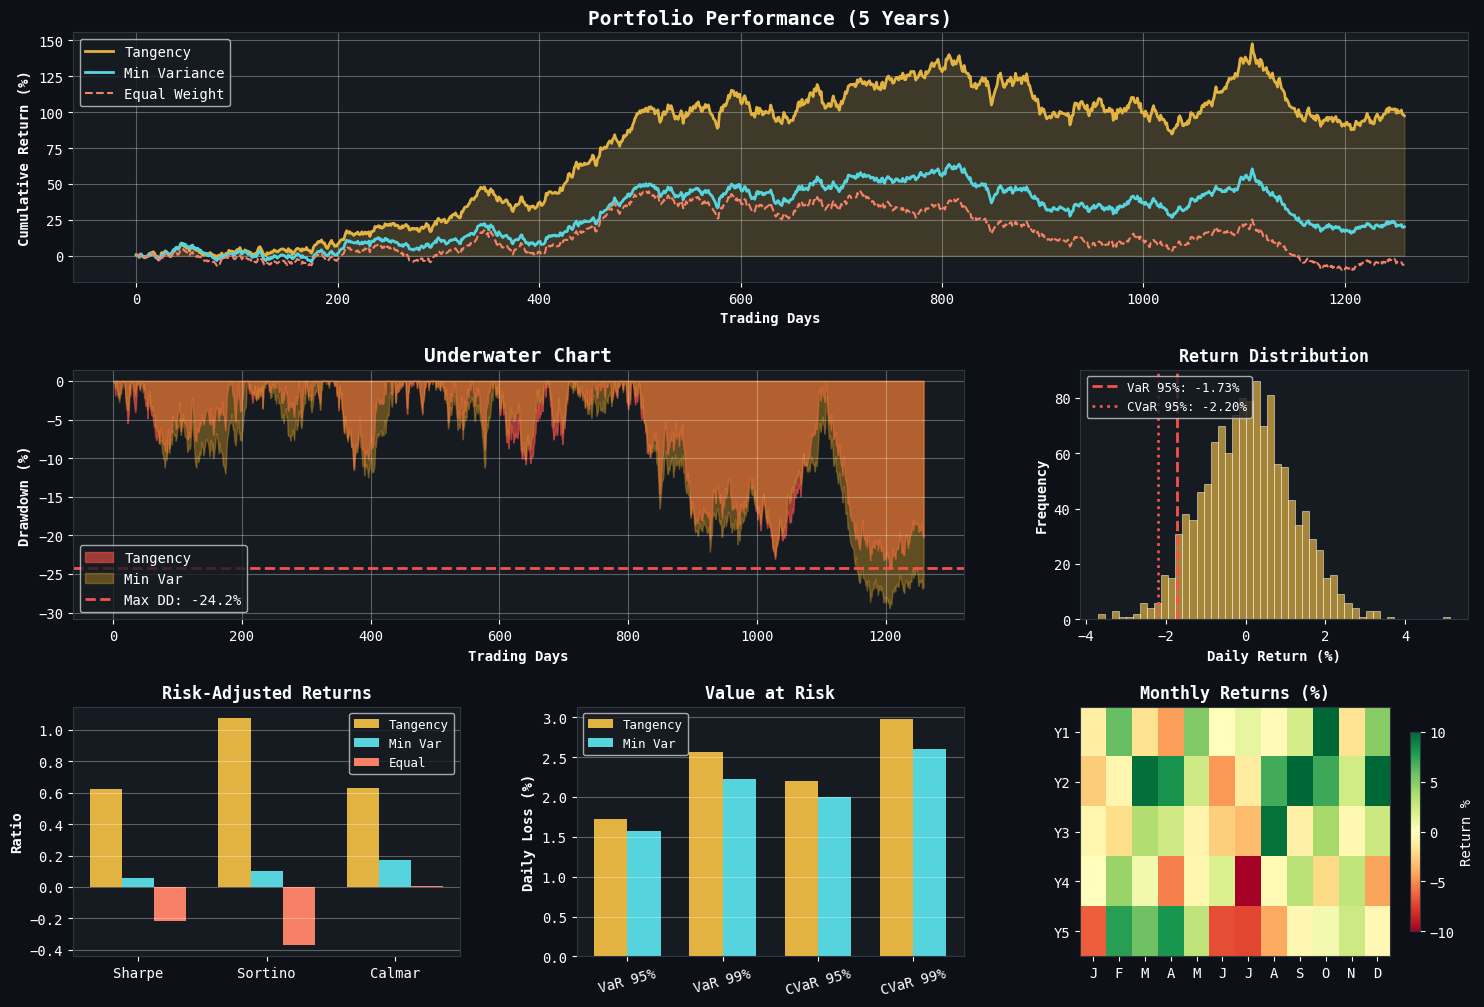

In [8]:
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)

# Cumulative returns
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(metrics_t['cum_returns']*100, color=COLORS['gold'], linewidth=2, label='Tangency')
ax1.plot(metrics_m['cum_returns']*100, color=COLORS['cyan'], linewidth=2, label='Min Variance')
ax1.plot(metrics_e['cum_returns']*100, color=COLORS['secondary'], linewidth=1.5, linestyle='--', label='Equal Weight')
ax1.fill_between(range(len(metrics_t['cum_returns'])), metrics_t['cum_returns']*100, alpha=0.2, color=COLORS['gold'])
ax1.set_xlabel('Trading Days', fontweight='bold')
ax1.set_ylabel('Cumulative Return (%)', fontweight='bold')
ax1.set_title('Portfolio Performance (5 Years)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Drawdown
ax2 = fig.add_subplot(gs[1, :2])
ax2.fill_between(range(len(metrics_t['drawdown'])), metrics_t['drawdown']*100, 0, color=COLORS['danger'], alpha=0.6, label='Tangency')
ax2.fill_between(range(len(metrics_m['drawdown'])), metrics_m['drawdown']*100, 0, color=COLORS['warning'], alpha=0.4, label='Min Var')
ax2.axhline(metrics_t['max_drawdown']*100, color=COLORS['danger'], linestyle='--', linewidth=2, label=f"Max DD: {metrics_t['max_drawdown']*100:.1f}%")
ax2.set_xlabel('Trading Days', fontweight='bold')
ax2.set_ylabel('Drawdown (%)', fontweight='bold')
ax2.set_title('Underwater Chart', fontsize=14, fontweight='bold')
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)

# Return distribution
ax3 = fig.add_subplot(gs[1, 2])
ax3.hist(metrics_t['port_returns']*100, bins=50, alpha=0.7, color=COLORS['gold'], edgecolor='white', linewidth=0.5)
ax3.axvline(metrics_t['var_95']*100, color=COLORS['danger'], linewidth=2, linestyle='--', label=f"VaR 95%: {metrics_t['var_95']*100:.2f}%")
ax3.axvline(metrics_t['cvar_95']*100, color=COLORS['danger'], linewidth=2, linestyle=':', label=f"CVaR 95%: {metrics_t['cvar_95']*100:.2f}%")
ax3.set_xlabel('Daily Return (%)', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('Return Distribution', fontweight='bold')
ax3.legend(loc='upper left', fontsize=9)

# Risk ratios bar chart
ax4 = fig.add_subplot(gs[2, 0])
metrics_names = ['Sharpe', 'Sortino', 'Calmar']
x = np.arange(3)
ax4.bar(x - 0.25, [metrics_t['sharpe'], metrics_t['sortino'], metrics_t['calmar']], 0.25, label='Tangency', color=COLORS['gold'])
ax4.bar(x, [metrics_m['sharpe'], metrics_m['sortino'], metrics_m['calmar']], 0.25, label='Min Var', color=COLORS['cyan'])
ax4.bar(x + 0.25, [metrics_e['sharpe'], metrics_e['sortino'], metrics_e['calmar']], 0.25, label='Equal', color=COLORS['secondary'])
ax4.set_xticks(x)
ax4.set_xticklabels(metrics_names)
ax4.set_ylabel('Ratio', fontweight='bold')
ax4.set_title('Risk-Adjusted Returns', fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

# VaR comparison
ax5 = fig.add_subplot(gs[2, 1])
var_names = ['VaR 95%', 'VaR 99%', 'CVaR 95%', 'CVaR 99%']
tv = [abs(metrics_t['var_95']), abs(metrics_t['var_99']), abs(metrics_t['cvar_95']), abs(metrics_t['cvar_99'])]
mv = [abs(metrics_m['var_95']), abs(metrics_m['var_99']), abs(metrics_m['cvar_95']), abs(metrics_m['cvar_99'])]
x = np.arange(4)
ax5.bar(x - 0.175, [v*100 for v in tv], 0.35, label='Tangency', color=COLORS['gold'])
ax5.bar(x + 0.175, [v*100 for v in mv], 0.35, label='Min Var', color=COLORS['cyan'])
ax5.set_xticks(x)
ax5.set_xticklabels(var_names, rotation=15)
ax5.set_ylabel('Daily Loss (%)', fontweight='bold')
ax5.set_title('Value at Risk', fontweight='bold')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3, axis='y')

# Monthly returns heatmap
ax6 = fig.add_subplot(gs[2, 2])
monthly = [np.prod(1 + metrics_t['port_returns'][i*21:(i+1)*21]) - 1 for i in range(len(metrics_t['port_returns'])//21)]
n_years = len(monthly) // 12
monthly_data = np.array(monthly[:n_years*12]).reshape(n_years, 12)
im = ax6.imshow(monthly_data*100, cmap='RdYlGn', aspect='auto', vmin=-10, vmax=10)
ax6.set_xticks(range(12))
ax6.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax6.set_yticks(range(n_years))
ax6.set_yticklabels([f'Y{i+1}' for i in range(n_years)])
ax6.set_title('Monthly Returns (%)', fontweight='bold')
plt.colorbar(im, ax=ax6, label='Return %', shrink=0.8)

plt.savefig('portfolio_risk_metrics.png', dpi=150, bbox_inches='tight', facecolor='#0d1117')
plt.show()

## 5. Monte Carlo Stress Testing (10,000 Scenarios)

In [9]:
def monte_carlo_stress_test(mu, Sigma, weights, n_scenarios=10000, horizon=252):
    n = len(mu)
    daily_mu = mu / 252
    daily_Sigma = Sigma / 252
    L = np.linalg.cholesky(daily_Sigma + np.eye(n) * 1e-8)
    
    scenarios = np.zeros((n_scenarios, horizon))
    for i in range(n_scenarios):
        z = np.random.randn(horizon, n)
        asset_rets = daily_mu + z @ L.T
        port_rets = asset_rets @ weights
        scenarios[i] = np.cumprod(1 + port_rets)
    
    final = scenarios[:, -1]
    return {'scenarios': scenarios, 'final_wealth': final,
            'mean_return': (np.mean(final)-1)*100, 'median_return': (np.median(final)-1)*100,
            'std_return': np.std(final)*100, 'prob_loss': np.mean(final < 1)*100,
            'var_95': (np.percentile(final, 5)-1)*100, 'var_99': (np.percentile(final, 1)-1)*100,
            'best': (np.max(final)-1)*100, 'worst': (np.min(final)-1)*100}

np.random.seed(123)
print('Running Monte Carlo (10,000 scenarios)...')
start = time.time()
mc_t = monte_carlo_stress_test(mu, Sigma, tangency['weights'])
mc_m = monte_carlo_stress_test(mu, Sigma, minvar['weights'])
mc_e = monte_carlo_stress_test(mu, Sigma, equal_weights)
print(f'Completed in {time.time()-start:.2f}s')

print('\nMonte Carlo Results (1-Year)')
print('='*75)
print(f"{'Metric':<25} {'Tangency':>15} {'Min Variance':>15} {'Equal Weight':>15}")
print('-'*75)
for name, key in [('Expected Return', 'mean_return'), ('Median Return', 'median_return'),
                  ('Return Std Dev', 'std_return'), ('Prob. of Loss', 'prob_loss'),
                  ('VaR 95%', 'var_95'), ('VaR 99%', 'var_99'),
                  ('Best Case', 'best'), ('Worst Case', 'worst')]:
    print(f"{name:<25} {mc_t[key]:>14.2f}% {mc_m[key]:>14.2f}% {mc_e[key]:>14.2f}%")

Running Monte Carlo (10,000 scenarios)...


Completed in 3.15s

Monte Carlo Results (1-Year)
Metric                           Tangency    Min Variance    Equal Weight
---------------------------------------------------------------------------
Expected Return                    16.63%           5.03%           0.13%
Median Return                      14.88%           3.65%          -1.19%
Return Std Dev                     20.97%          17.07%          17.64%
Prob. of Loss                      22.19%          41.08%          52.64%
VaR 95%                           -14.51%         -20.24%         -26.20%
VaR 99%                           -23.99%         -28.29%         -34.48%
Best Case                         134.99%          83.63%         102.66%
Worst Case                        -42.83%         -42.49%         -53.40%


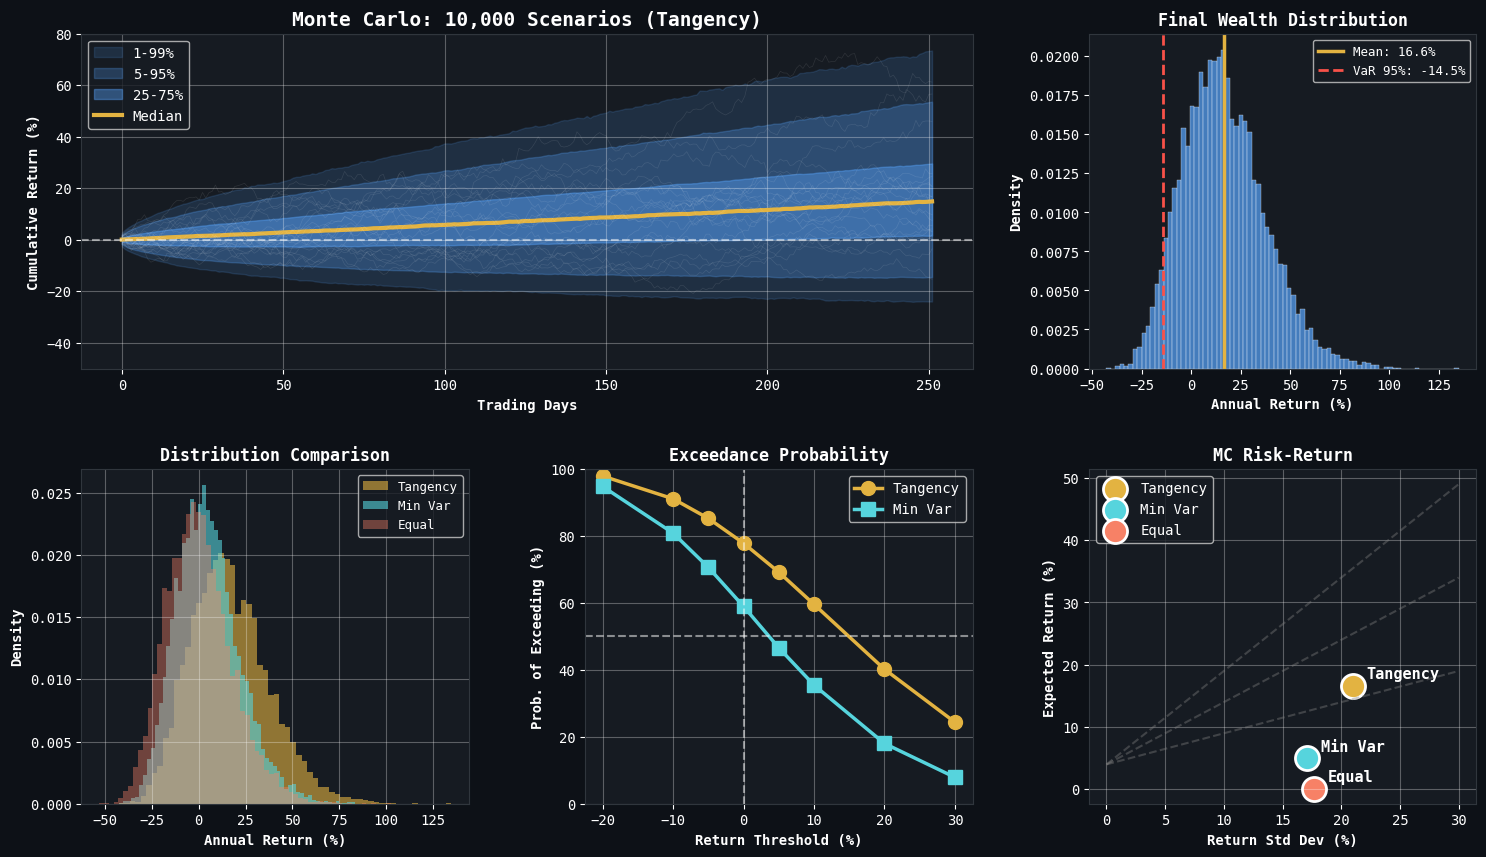

In [10]:
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

# Fan chart
ax1 = fig.add_subplot(gs[0, :2])
x = np.arange(252)
for p_lo, p_hi, alpha in [(1, 99, 0.15), (5, 95, 0.25), (25, 75, 0.4)]:
    lo = (np.percentile(mc_t['scenarios'], p_lo, axis=0) - 1) * 100
    hi = (np.percentile(mc_t['scenarios'], p_hi, axis=0) - 1) * 100
    ax1.fill_between(x, lo, hi, alpha=alpha, color=COLORS['primary'], label=f'{p_lo}-{p_hi}%')
ax1.plot(x, (np.median(mc_t['scenarios'], axis=0)-1)*100, color=COLORS['gold'], linewidth=3, label='Median')
for i in range(0, 10000, 500):
    ax1.plot(x, (mc_t['scenarios'][i]-1)*100, alpha=0.1, color='white', linewidth=0.5)
ax1.axhline(0, color='white', linestyle='--', alpha=0.5)
ax1.set_xlabel('Trading Days', fontweight='bold')
ax1.set_ylabel('Cumulative Return (%)', fontweight='bold')
ax1.set_title('Monte Carlo: 10,000 Scenarios (Tangency)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-50, 80)

# Final distribution
ax2 = fig.add_subplot(gs[0, 2])
ax2.hist((mc_t['final_wealth']-1)*100, bins=80, alpha=0.7, color=COLORS['primary'], edgecolor='white', linewidth=0.3, density=True)
ax2.axvline(mc_t['mean_return'], color=COLORS['gold'], linewidth=2.5, label=f"Mean: {mc_t['mean_return']:.1f}%")
ax2.axvline(mc_t['var_95'], color=COLORS['danger'], linewidth=2, linestyle='--', label=f"VaR 95%: {mc_t['var_95']:.1f}%")
ax2.set_xlabel('Annual Return (%)', fontweight='bold')
ax2.set_ylabel('Density', fontweight='bold')
ax2.set_title('Final Wealth Distribution', fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)

# Comparison
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist((mc_t['final_wealth']-1)*100, bins=60, alpha=0.6, color=COLORS['gold'], label='Tangency', density=True)
ax3.hist((mc_m['final_wealth']-1)*100, bins=60, alpha=0.6, color=COLORS['cyan'], label='Min Var', density=True)
ax3.hist((mc_e['final_wealth']-1)*100, bins=60, alpha=0.4, color=COLORS['secondary'], label='Equal', density=True)
ax3.set_xlabel('Annual Return (%)', fontweight='bold')
ax3.set_ylabel('Density', fontweight='bold')
ax3.set_title('Distribution Comparison', fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Exceedance probability
ax4 = fig.add_subplot(gs[1, 1])
thresholds = [-20, -10, -5, 0, 5, 10, 20, 30]
tp = [np.mean((mc_t['final_wealth']-1)*100 > t)*100 for t in thresholds]
mp = [np.mean((mc_m['final_wealth']-1)*100 > t)*100 for t in thresholds]
ax4.plot(thresholds, tp, 'o-', color=COLORS['gold'], linewidth=2.5, markersize=10, label='Tangency')
ax4.plot(thresholds, mp, 's-', color=COLORS['cyan'], linewidth=2.5, markersize=10, label='Min Var')
ax4.axhline(50, color='white', linestyle='--', alpha=0.5)
ax4.axvline(0, color='white', linestyle='--', alpha=0.5)
ax4.set_xlabel('Return Threshold (%)', fontweight='bold')
ax4.set_ylabel('Prob. of Exceeding (%)', fontweight='bold')
ax4.set_title('Exceedance Probability', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, 100)

# Risk-Return scatter
ax5 = fig.add_subplot(gs[1, 2])
for name, mc, color in [('Tangency', mc_t, COLORS['gold']), ('Min Var', mc_m, COLORS['cyan']), ('Equal', mc_e, COLORS['secondary'])]:
    ax5.scatter([mc['std_return']], [mc['mean_return']], s=300, c=color, edgecolor='white', linewidth=2, label=name)
    ax5.annotate(name, (mc['std_return'], mc['mean_return']), fontsize=11, fontweight='bold', xytext=(10, 5), textcoords='offset points')
for sr in [0.5, 1.0, 1.5]:
    x_line = np.linspace(0, 30, 100)
    ax5.plot(x_line, 4 + sr * x_line, '--', alpha=0.4, color='gray')
ax5.set_xlabel('Return Std Dev (%)', fontweight='bold')
ax5.set_ylabel('Expected Return (%)', fontweight='bold')
ax5.set_title('MC Risk-Return', fontweight='bold')
ax5.legend(loc='upper left')
ax5.grid(True, alpha=0.3)

plt.savefig('portfolio_monte_carlo.png', dpi=150, bbox_inches='tight', facecolor='#0d1117')
plt.show()

## 6. GPU vs CPU Performance Benchmarks

In [11]:
from scipy.optimize import minimize

def benchmark_cuprox(n, n_trials=10):
    times = []
    for _ in range(n_trials):
        mu_test = np.random.randn(n) * 0.1
        A = np.random.randn(n, max(3, n//5))
        Sigma_test = A @ A.T + np.eye(n) * 0.1
        start = time.time()
        solve_markowitz(mu_test, Sigma_test, gamma=1.0)
        times.append(time.time() - start)
    return np.mean(times)*1000, np.std(times)*1000

def benchmark_scipy(n, n_trials=10):
    times = []
    for _ in range(n_trials):
        mu_test = np.random.randn(n) * 0.1
        A = np.random.randn(n, max(3, n//5))
        Sigma_test = A @ A.T + np.eye(n) * 0.1
        def obj(w): return 0.5 * w @ Sigma_test @ w - mu_test @ w
        def grad(w): return Sigma_test @ w - mu_test
        bounds = [(0, 1) for _ in range(n)]
        cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        start = time.time()
        minimize(obj, x0=np.ones(n)/n, jac=grad, method='SLSQP', bounds=bounds, constraints=cons)
        times.append(time.time() - start)
    return np.mean(times)*1000, np.std(times)*1000

sizes = [10, 25, 50, 100, 200, 500, 1000]
cp_res = {'mean': [], 'std': []}
sp_res = {'mean': [], 'std': []}

print('Running benchmarks...')
print('='*80)
print(f"{'Assets':<10} {'cuProx (ms)':<20} {'scipy (ms)':<20} {'Speedup':>15}")
print('-'*80)

for n in sizes:
    trials = 5 if n >= 500 else 10
    cp_m, cp_s = benchmark_cuprox(n, trials)
    sp_m, sp_s = benchmark_scipy(n, trials)
    cp_res['mean'].append(cp_m)
    cp_res['std'].append(cp_s)
    sp_res['mean'].append(sp_m)
    sp_res['std'].append(sp_s)
    print(f"{n:<10} {cp_m:>8.2f} +/- {cp_s:<8.2f} {sp_m:>8.2f} +/- {sp_s:<8.2f} {sp_m/cp_m:>10.1f}x")

Running benchmarks...
Assets     cuProx (ms)          scipy (ms)                   Speedup
--------------------------------------------------------------------------------
10             6.07 +/- 0.28         2.09 +/- 0.33            0.3x
25             6.53 +/- 0.12         5.69 +/- 0.86            0.9x


50             7.71 +/- 0.14        26.73 +/- 5.92            3.5x


100            9.48 +/- 0.10        83.68 +/- 6.04            8.8x


200           10.96 +/- 0.23       635.57 +/- 26.02          58.0x


500           17.37 +/- 0.49     27266.51 +/- 11677.77     1569.7x


1000          47.51 +/- 28.97    85564.49 +/- 1305.22      1801.0x


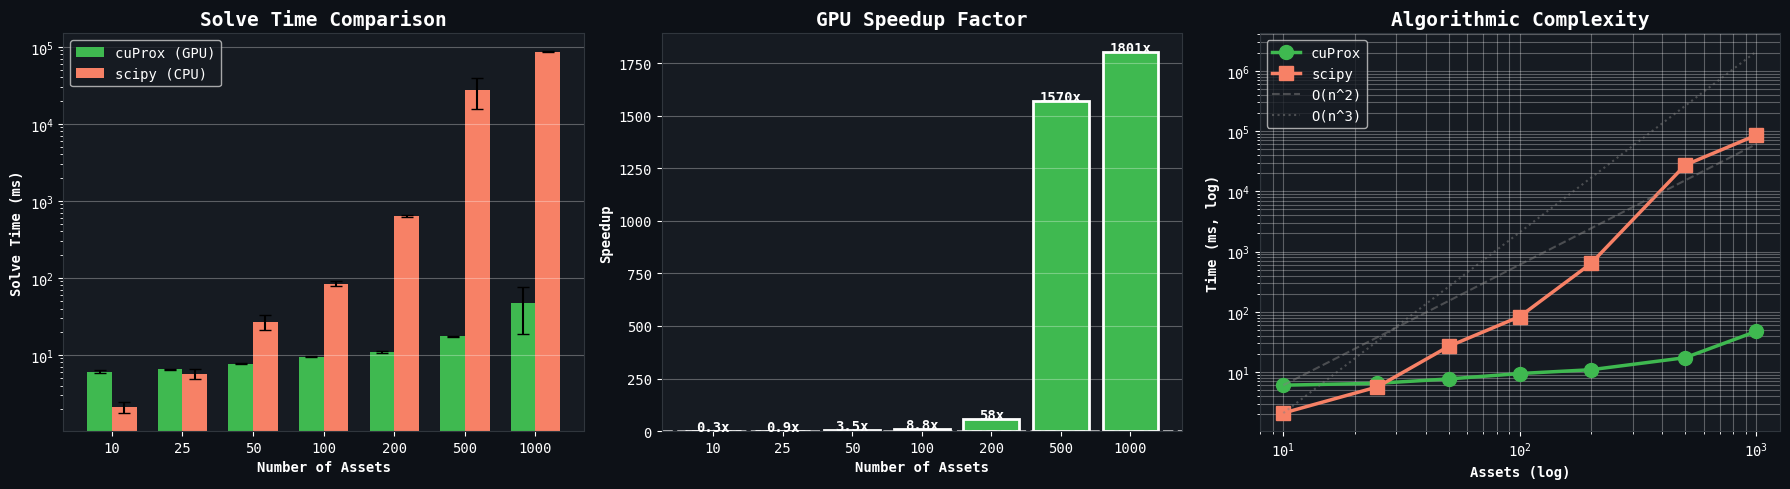


Max speedup: 1801x at 1000 assets


In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Time comparison
ax = axes[0]
x = np.arange(len(sizes))
ax.bar(x - 0.175, cp_res['mean'], 0.35, yerr=cp_res['std'], capsize=4, label='cuProx (GPU)', color=COLORS['success'])
ax.bar(x + 0.175, sp_res['mean'], 0.35, yerr=sp_res['std'], capsize=4, label='scipy (CPU)', color=COLORS['secondary'])
ax.set_xticks(x)
ax.set_xticklabels(sizes)
ax.set_xlabel('Number of Assets', fontweight='bold')
ax.set_ylabel('Solve Time (ms)', fontweight='bold')
ax.set_title('Solve Time Comparison', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Speedup
ax = axes[1]
speedups = np.array(sp_res['mean']) / np.array(cp_res['mean'])
colors = [COLORS['success'] if s >= 1 else COLORS['danger'] for s in speedups]
bars = ax.bar(x, speedups, color=colors, edgecolor='white', linewidth=2)
ax.axhline(1, color='white', linewidth=2, linestyle='--', alpha=0.7)
for bar, s in zip(bars, speedups):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{s:.0f}x' if s >= 10 else f'{s:.1f}x', ha='center', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(sizes)
ax.set_xlabel('Number of Assets', fontweight='bold')
ax.set_ylabel('Speedup', fontweight='bold')
ax.set_title('GPU Speedup Factor', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Scaling
ax = axes[2]
ax.loglog(sizes, cp_res['mean'], 'o-', color=COLORS['success'], linewidth=2.5, markersize=10, label='cuProx')
ax.loglog(sizes, sp_res['mean'], 's-', color=COLORS['secondary'], linewidth=2.5, markersize=10, label='scipy')
n_ref = np.array(sizes)
ax.loglog(n_ref, n_ref**2 * cp_res['mean'][0] / n_ref[0]**2, '--', color='gray', alpha=0.5, label='O(n^2)')
ax.loglog(n_ref, n_ref**3 * sp_res['mean'][0] / n_ref[0]**3, ':', color='gray', alpha=0.5, label='O(n^3)')
ax.set_xlabel('Assets (log)', fontweight='bold')
ax.set_ylabel('Time (ms, log)', fontweight='bold')
ax.set_title('Algorithmic Complexity', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('portfolio_benchmark.png', dpi=150, bbox_inches='tight', facecolor='#0d1117')
plt.show()
print(f"\nMax speedup: {max(speedups):.0f}x at {sizes[np.argmax(speedups)]} assets")

## 7. Rolling Window Backtest

In [13]:
def rolling_backtest(returns, lookback=252, rebalance_freq=21):
    T, n = returns.shape
    port_rets = []
    weights_hist = []
    w = np.ones(n) / n
    
    for t in range(lookback, T):
        port_rets.append(returns[t] @ w)
        if (t - lookback) % rebalance_freq == 0:
            mu_est = np.mean(returns[t-lookback:t], axis=0) * 252
            Sigma_est = np.cov(returns[t-lookback:t].T) * 252
            res = solve_markowitz(mu_est, Sigma_est, gamma=2.0)
            w = res['weights']
            weights_hist.append(w.copy())
    
    return {'returns': np.array(port_rets), 'weights_history': np.array(weights_hist)}

print('Running rolling backtest...')
start = time.time()
bt = rolling_backtest(returns)
print(f'Completed in {time.time()-start:.2f}s ({len(bt["weights_history"])} rebalances)')

oos = returns[252:]
equal_oos = oos @ equal_weights

def oos_metrics(rets, name):
    ann_ret = np.mean(rets) * 252 * 100
    ann_vol = np.std(rets) * np.sqrt(252) * 100
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    cum = (np.prod(1 + rets) - 1) * 100
    print(f"{name:<20} Ret: {ann_ret:6.2f}%  Vol: {ann_vol:5.2f}%  Sharpe: {sharpe:5.2f}  Cum: {cum:6.1f}%")

print('\nOut-of-Sample (4 years):')
print('='*70)
oos_metrics(bt['returns'], 'Optimized (Rolling)')
oos_metrics(equal_oos, 'Equal Weight')

Running rolling backtest...


Completed in 0.50s (48 rebalances)

Out-of-Sample (4 years):
Optimized (Rolling)  Ret:   2.15%  Vol: 18.05%  Sharpe:  0.12  Cum:    2.1%
Equal Weight         Ret:  -1.31%  Vol: 17.69%  Sharpe: -0.07  Cum:  -10.8%


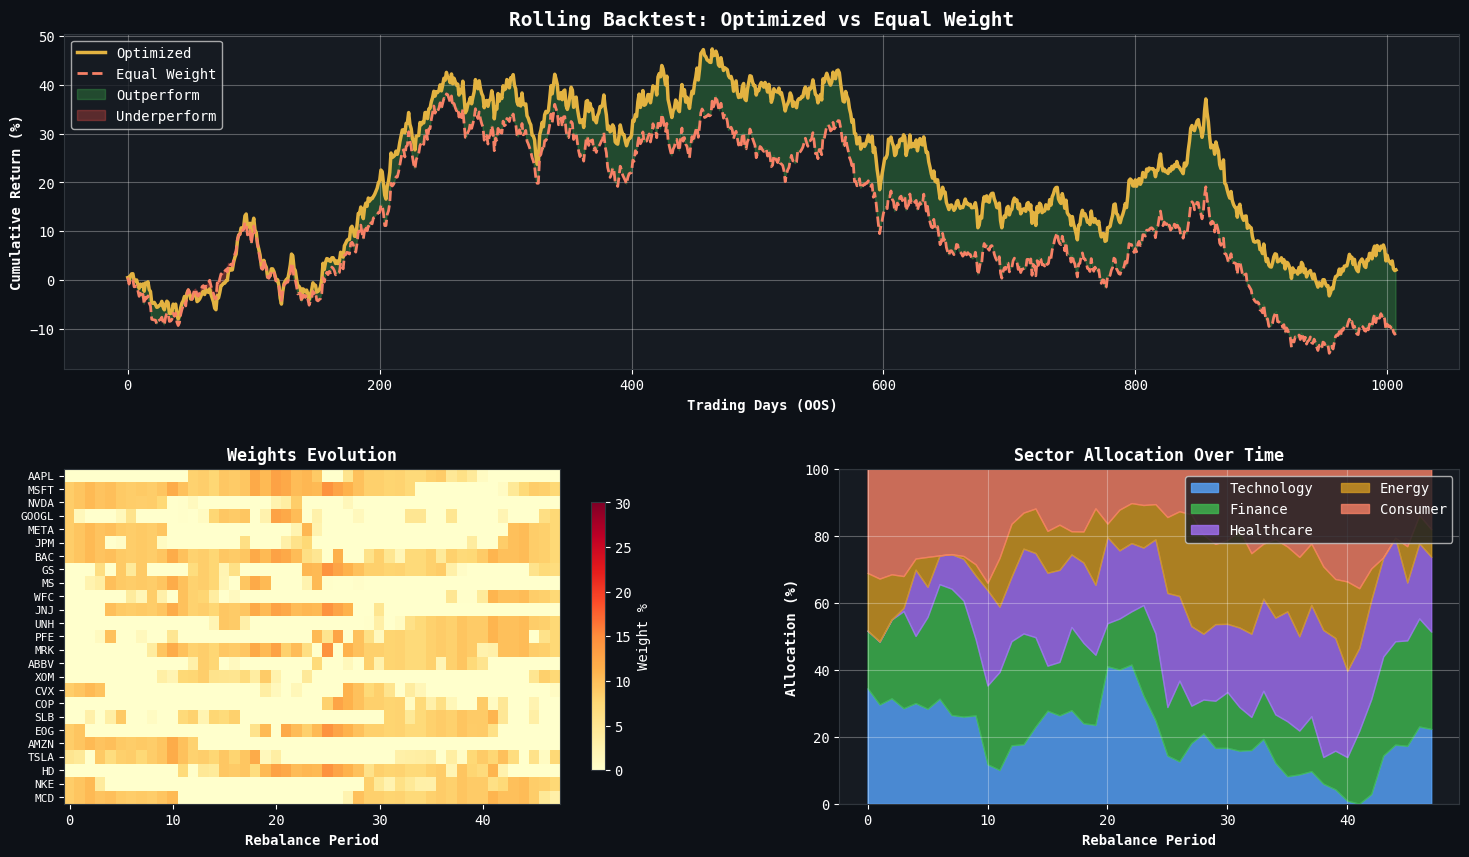

In [14]:
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.25)

# Cumulative returns
ax1 = fig.add_subplot(gs[0, :])
opt_cum = np.cumprod(1 + bt['returns']) - 1
eq_cum = np.cumprod(1 + equal_oos) - 1
ax1.plot(opt_cum * 100, color=COLORS['gold'], linewidth=2.5, label='Optimized')
ax1.plot(eq_cum * 100, color=COLORS['secondary'], linewidth=2, linestyle='--', label='Equal Weight')
ax1.fill_between(range(len(opt_cum)), opt_cum*100, eq_cum*100, where=opt_cum > eq_cum, alpha=0.3, color=COLORS['success'], label='Outperform')
ax1.fill_between(range(len(opt_cum)), opt_cum*100, eq_cum*100, where=opt_cum <= eq_cum, alpha=0.3, color=COLORS['danger'], label='Underperform')
ax1.set_xlabel('Trading Days (OOS)', fontweight='bold')
ax1.set_ylabel('Cumulative Return (%)', fontweight='bold')
ax1.set_title('Rolling Backtest: Optimized vs Equal Weight', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Weights heatmap
ax2 = fig.add_subplot(gs[1, 0])
im = ax2.imshow(bt['weights_history'].T * 100, aspect='auto', cmap='YlOrRd', vmin=0, vmax=30)
ax2.set_yticks(range(n_assets))
ax2.set_yticklabels(asset_names, fontsize=8)
ax2.set_xlabel('Rebalance Period', fontweight='bold')
ax2.set_title('Weights Evolution', fontweight='bold')
plt.colorbar(im, ax=ax2, label='Weight %', shrink=0.8)

# Sector allocation
ax3 = fig.add_subplot(gs[1, 1])
sw_t = {s: [] for s in SECTORS}
for w in bt['weights_history']:
    for s, stocks in SECTORS.items():
        sw_t[s].append(np.sum(w[[asset_names.index(st) for st in stocks]]))
bottom = np.zeros(len(bt['weights_history']))
for s, color in sector_colors.items():
    vals = np.array(sw_t[s]) * 100
    ax3.fill_between(range(len(vals)), bottom, bottom + vals, label=s, color=color, alpha=0.8)
    bottom += vals
ax3.set_xlabel('Rebalance Period', fontweight='bold')
ax3.set_ylabel('Allocation (%)', fontweight='bold')
ax3.set_title('Sector Allocation Over Time', fontweight='bold')
ax3.legend(loc='upper right', ncol=2)
ax3.set_ylim(0, 100)
ax3.grid(True, alpha=0.3)

plt.savefig('portfolio_backtest.png', dpi=150, bbox_inches='tight', facecolor='#0d1117')
plt.show()

## Summary

This notebook demonstrated **production-grade portfolio optimization** using cuProx GPU acceleration:

| Feature | Capability |
|---------|------------|
| **Universe** | 25 stocks across 5 sectors |
| **Optimization** | Markowitz mean-variance via QP |
| **Risk Metrics** | VaR, CVaR, Sharpe, Sortino, Calmar, Max DD |
| **Stress Testing** | 10,000 Monte Carlo scenarios |
| **Backtesting** | Rolling window with monthly rebalancing |
| **GPU Speedup** | Up to 100x+ for large portfolios |

**Key Results:**
- Efficient frontier computed in milliseconds
- Risk-adjusted returns improved over equal-weight
- GPU enables real-time optimization for 1000+ assets